# A Practical Guide to Using Visual Studio Code and Python for Machine Learning in Small‑Molecule Drug Discovery, Design, and Optimization

## Purpose of This Guide

This guidebook provides a **step‑by‑step, end‑to‑end workflow** for applying Python‑based machine learning to **small‑molecule drug discovery** using **Visual Studio Code (VS Code)** as the primary development environment. It is designed for students, researchers, and professionals in medicinal chemistry, CADD, and pharmaceutical sciences.

The guide emphasizes **practical implementation**, reproducibility, and industry‑relevant best practices across:

* Data cleaning and curation
* Molecular descriptor calculation
* QSAR and ML model development
* Model validation and interpretation
* Bioactivity prediction and virtual screening
* Drug‑likeness and Lipinski filtering
* Visualization and reporting
* Deployment and reuse of models

**Author:** **Abdullahi Abubakar Sadiq**

_Date:_ **_20th January 2026_**


## Part 1: Environment Setup and Tooling

### 1.1 Installing Visual Studio Code

**Step 1: Install VS Code**

* Download VS Code for your OS
* Install and launch

**Step 2: Install Essential Extensions**

* Python (Microsoft)
* Jupyter
* Pylance
* autopep8

* Etc.

**Step 3: Verify Python Integration**


In [4]:
import sys
print(sys.executable)
print(sys.version)


c:\Users\PC\AppData\Local\Programs\Python\Python312\python.exe
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:39) [MSC v.1935 64 bit (AMD64)]


### 1.3 Installing Required Libraries
Python libraries are collections of pre-written code (modules and packages) that provide specific functionalities to perform common tasks, allowing researchers to avoid writing code from scratch. They significantly extend Python's capabilities in various domains such as data science, web development, and machine learning. 

#### Core Python Libraries for Drug Discovery ML

* **Data handling**: pandas, numpy, scipy
* **Chemoinformatics**: RDKit, Mordred
* **ML frameworks**: scikit‑learn, XGBoost, LightGBM
* **Visualization**: matplotlib, seaborn, plotly
* **Deployment**: joblib, FastAPI

In [5]:
pip! install pandas numpy scikit-learn rdkit-pypi matplotlib seaborn joblib shap xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "!"



In [8]:
# The start of a typical ML Script for regression data looks like this;
# ======================================================
# 1. IMPORT LIBRARIES
# ======================================================

# pandas: handles tabular data like Excel or CSV files
import pandas as pd

# rdkit: a chemical informatics library for molecule manipulation
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Avalon import pyAvalonTools

# numpy: numerical operations for arrays (used in fingerprints and ML)
import numpy as np

# scikit-learn: machine learning tools
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ML libraries for advanced models
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

# Matplotlib for plotting and visualizations
import matplotlib.pyplot as plt

# joblib: save and load trained models
import joblib


## Part 2: Data Sources and Dataset Preparation

### 2.1 Common Data Sources

* ChEMBL
* PubChem
* BindingDB
* MMV Open Access Box
* In‑house or experimental datasets

### 2.2 Understanding Typical Drug Discovery Datasets

* SMILES strings
* Bioactivity values (IC50, EC50, Ki, pIC50)
* Assay metadata

### 2.3 Data Import and Inspection

* Loading CSV and excel files
* Initial sanity checks:

  * Missing values
  * Duplicates
  * Invalid SMILES

In [9]:
df = pd.read_csv("Train.csv")

In [13]:
# ===========================
# EXAMPLE: Loading and cleaning of Data.
# ===========================
from rdkit import Chem
import pandas as pd

# ===========================
# 2. LOAD & CLEAN TRAINING DATA
# ===========================

# Load training dataset
df = pd.read_csv("Train.csv")

# Defensive column selection
required_cols = ["Smiles", "pChEMBL Value"]
df = df[required_cols + [c for c in df.columns if c not in required_cols]]

# Track initial size
initial_train_rows = df.shape[0]

# Drop missing critical values
df = df.dropna(subset=["Smiles", "pChEMBL Value"]).reset_index(drop=True)

# Ensure correct data types and normalize SMILES
df["Smiles"] = df["Smiles"].astype(str).str.strip()
df["pChEMBL Value"] = pd.to_numeric(df["pChEMBL Value"], errors="coerce")

# Drop rows that became invalid after coercion
df = df.dropna(subset=["pChEMBL Value"]).reset_index(drop=True)

# Remove duplicate SMILES (keep first occurrence)
df = df.drop_duplicates(subset=["Smiles"]).reset_index(drop=True)

# Validate SMILES with RDKit
def is_valid_smiles(smi):
    return Chem.MolFromSmiles(smi) is not None

df["valid_smiles"] = df["Smiles"].apply(is_valid_smiles)
df = df[df["valid_smiles"]].drop(columns="valid_smiles").reset_index(drop=True)

# Final report
print(
    f"Training dataset cleaned: "
    f"{initial_train_rows - df.shape[0]} rows removed, "
    f"{df.shape[0]} valid compounds remaining."
)


Training dataset cleaned: 606 rows removed, 3251 valid compounds remaining.


## Part 3: Conversion of SMILES to Molecules
For most ML workflows, SMILES strings must be converted to an RDKit molecule object and subsequently to a fixed-length numerical representation (like a molecular fingerprint or descriptor vector) because most traditional machine learning models require inputs to be numerical and of a uniform size. Raw SMILES strings, being variable-length text sequences, do not inherently meet these criteria. 

#### This conversion is neccessary because:
##### 1. Machine Learning Requires Numerical Input
##### 2. Fixed Input Length.
##### 3. Capturing Chemical Information.
##### 4. Data Validation and Standardization.


In [14]:
# EXAMPLE; Converting SMILES to Molecules

def smiles_to_mols(smiles_list):
    """
    Convert SMILES strings to RDKit molecule objects.
    Ignore invalid SMILES.
    """
    mols = []       # List to store valid molecules
    valid_idx = []  # Index of valid molecules
    for i, smi in enumerate(smiles_list):
        mol = Chem.MolFromSmiles(smi)  # Convert SMILES to molecule
        if mol:  # Only keep valid molecules
            mols.append(mol)
            valid_idx.append(i)
    return mols, valid_idx

## Part 4: Molecular Descriptor and Fingerprint Calculation
Molecular descriptors can be seen as numerical representations of molecular structures. Such descriptors are prerequisite for ML tasks. 

### 4.1 Numerical Descriptor Types

* Physicochemical descriptors: Examples include Lipophilicity (logP), refractivity, Topological Polar Surface Area (TPSA), Solubility index etc.
* Topological descriptors: refer to descriptors that  take into account connectivity along with atom and bond labels.
* Constitutional descriptors: These descriptors only require atom and bond labels and usually represent counts of different types of atoms or bonds.Examples include atom counts, bond counts, and functional group counts.

### 4.2 Fingerprints: Traditionally, fingerprint descriptors are molecular representations in the form of bit strings. Examples include;

* ECFP (Morgan fingerprints)
* MACCS keys
* Avalon fingerprints

### CITATIONS: 1. Guha R, Willighagen E. A survey of quantitative descriptions of molecular structure. Curr Top Med Chem. 2012;12(18):1946-56. doi: 10.2174/156802612804910278. PMID: 23110530; PMCID: PMC3809149.
---

In [15]:
# EXAMPLE 4a: Calculating Fingerprints
def calculate_fingerprints(df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024):
    """
    Compute molecular fingerprints (ECFP or Avalon) for all molecules.
    Fingerprints are numeric representations of molecular structure.
    """
    smiles_list = df[smiles_col]
    mols, valid_idx = smiles_to_mols(smiles_list)
    fingerprints = []

    for mol in mols:
        # ECFP (Morgan) fingerprint
        if method == 'ecfp':
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
        # Avalon fingerprint
        elif method == 'avalon':
            fp = pyAvalonTools.GetAvalonFP(mol, nBits=nBits)
        else:
            raise ValueError("Method must be 'ecfp' or 'avalon'")

        # Convert fingerprint to numeric array
        fp_np = np.zeros((nBits,), dtype=np.uint8)
        DataStructs.ConvertToNumpyArray(fp, fp_np)
        fingerprints.append(fp_np)

    # Create DataFrame for fingerprints
    prefix = method.upper()
    fp_df = pd.DataFrame(fingerprints, columns=[f'{prefix}_{i}' for i in range(nBits)])
    fp_df.index = valid_idx

    # Keep only valid molecules
    df_valid = df.iloc[valid_idx].reset_index(drop=True)
    fp_df = fp_df.reset_index(drop=True)

    # Combine original data and fingerprint features
    return pd.concat([df_valid, fp_df], axis=1)


In [16]:
# EXAMPLE 4b: Calculating Fingerprints

df_with_ecfp = calculate_fingerprints(df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024)

# Define features (X) and target (y)
X = df_with_ecfp.drop(columns=['Smiles', 'Molecule ChEMBL ID', 'pChEMBL Value'])
y = df_with_ecfp['pChEMBL Value']

# Remove constant columns
X = X.loc[:, X.nunique() > 1]


[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerator
[22:10:27] DEPRECATION WARNING: please use MorganGenerat

## Part 5: Machine Learning Model Development
Machine learning models are broadly categorized into four primary types based on their learning approach: supervised learning, unsupervised learning, semi-supervised learning, and reinforcement learning.

### 1. Supervised Learning
In supervised learning, models are trained on a labeled dataset, which means the training data includes both input examples and their corresponding correct outputs (labels). Types include;

##### Classification: Predicts categorical or labelled outputs (e.g., classifying an email as "spam" or "not spam", or an molecule as a "Active" or "Not Active").
Common algorithms: Logistic regression, Naive Bayes, Random Forests and Support Vector Machines (SVM).

##### Regression: Predicts continuous, numerical outputs (e.g.,  predicting temperature or pIC50 values).
Common algorithms: Linear regression, Random Forest, Gradient Boosting, Lasso regression, and LightGBM.

### 2. Unsupervised Learning
Unsupervised learning models work with unlabeled data and are tasked with finding hidden patterns, structures, or relationships within the data on their own, without human guidance or a "correct" answer key. Types include;

##### Clustering: Groups similar data points into clusters based on shared characteristics (e.g., customer segmentation for targeted marketing).
Common algorithms: K-Means clustering, Hierarchical clustering, Mean-Shift, and DBSCAN.

##### Dimensionality Reduction: Simplifies complex datasets by reducing the number of variables while retaining important information, often for data visualization or preprocessing.
Common techniques: Principal Component Analysis (PCA) and t-Distributed Stochastic Neighbor Embedding (t-SNE).

##### Association: Discovers rules or correlations between different items in large databases (e.g., Diabetes comorbidity with hypertension studies or market basket analysis to find products often bought together).
Common algorithms: Apriori and FP-Growth. 

### 3. Semi-Supervised Learning
This approach combines a small amount of labeled data with a large amount of unlabeled data.
Common techniques: Self-training, and Generative Adversarial Networks (GANs). 

### 4. Reinforcement Learning
Reinforcement learning trains a model to make a sequence of decisions by interacting with an environment and receiving feedback in the form of rewards or penalties. The model learns through trial and error to identify the optimal strategy or "policy" to maximize the cumulative reward. 

Applications: Training agents to play games (like AlphaGo), robotics and automation, and autonomous vehicles.
Common algorithms: Q-learning and Policy Gradient methods. 

## IMPLEMENTATION
### 6.1 Problem Framing: Define the ML problem statement, For example

* Regression (QSAR): Prediction of a continuos numerical variables, e.g pIC50, Docking scores, etc.

* Classification: Predicts categories or labels. For example 'Active vs Inactive', 'Healthy vs Unhealthy', 'Inhibitor vs Non-inhibitor'. The condition that is desired is typically assigned '1' and the condition that is not desired '0'.

### 5.2 Train–Validation–Test Splits
Training Set: Used to fit model parameters. Here model learns relationships between molecular descriptors and bioactivity. It should be the largest portion of the data.

Validation Set: Used to tune hyperparameters, it guides model selection (e.g., RF vs XGBoost) and prevents overfitting during optimization.

Test Set: Used once, at the very end of the model development, it provides an unbiased estimate of real-world performance. This dataset must remain completely untouched during model development

NB: Cross-validation within the training set can also be used for hyperparameter optimization

## SUMMARY
### 5.3 Baseline Models

* Linear Regression
* Ridge / Lasso
* k‑Nearest Neighbors

### 5.4 Tree‑Based and Ensemble Models

* Random Forest
* Gradient Boosting
* XGBoost
* LightGBM

### 5.5 Hyperparameter Optimization

* Grid search
* Randomized search
* Cross‑validation strategies

#### CITATION: Katrina Wakefield, A guide to the types of machine learning algorithims and their applications, SAS UK, https://www.sas.com/en_gb/insights/articles/analytics/machine-learning-algorithms.html#:~:text=At%20its%20most%20basic%2C%20machine,%2Dsupervised%2C%20unsupervised%20and%20reinforcement.


In [18]:
# EXAMPLE 5A: Spilitting Data

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# 80% training, 20% testing


In [19]:
# EXAMPLE 5B: Defining Models

models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "GradBoost": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost": AdaBoostRegressor(n_estimators=100, random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(max_iter=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(n_estimators=100, random_state=42, verbose=0),
    "LightGBM": LGBMRegressor(n_estimators=100, random_state=42),
}


In [20]:
#EXAMPLE 5C: Train Models

results = []

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)        # Train model
    y_pred = model.predict(X_test)     # Predict on test set
    
    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, mse, rmse, r2])

Training RandomForest...
Training GradBoost...
Training AdaBoost...
Training HistGradientBoosting...
Training XGBoost...
Training CatBoost...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014264 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1586
[LightGBM] [Info] Number of data points in the train set: 2600, number of used features: 793
[LightGBM] [Info] Start training from score 7.157150


## Part 6: Model Evaluation and Validation

### 6.1 Regression Metrics

#### Error Metrics (Lower is Better)
* Mean Absolute Error (MAE): Average of absolute differences between predictions and actual values. Easy to interpret, treats all errors equally, robust to outliers.

* Mean Squared Error (MSE): Average of squared differences. Penalizes large errors more significantly, veyry useful when big mistakes are costly.

* Root Mean Squared Error (RMSE): Square root of MSE. Same units as the target variable, making it more interpretable than MSE while still penalizing large errors. 

#### Model Fit Metric (Higher is Better, typically 0-1)
R-Squared (R²): Coefficient of determination, representing the proportion of variance in the dependent variable explained by the model. A value closer to 1 means lower variability. 

### 6.2 Classification Metrics
True Positive (TP): Correctly predicted positive.
False Positive (FP): Incorrectly predicted positive (Type I error).
False Negative (FN): Incorrectly predicted negative (Type II error).
True Negative (TN): Correctly predicted negative.

* Accuracy: Overall correctness

* Precision: Of all predicted positives, how many were correct? (Minimizes false positives).

* Recall:  Of all actual positives, how many did the model find? (Minimizes false negatives).

* F1 Score: Harmonic mean of Precision and Recall; balances both, better for imbalanced data


###### CITATION AND FURTHER READING: scikit-learn, Metrics and scoring: quantifying the quality of predictions, User Guide, Model Selection and Evaluation, https://scikit-learn.org/stable/modules/model_evaluation.html

In [21]:
# EXAMPLE 6: Evaluating Models
# Convert results to DataFrame for comparison
results_df = pd.DataFrame(results, columns=["Model","MAE","MSE","RMSE","R2"])
results_df = results_df.sort_values("RMSE").reset_index(drop=True)
results_df["Rank"] = results_df["RMSE"].rank(method="first")
print("\nTop Models Ranked by RMSE:")
print(results_df)


Top Models Ranked by RMSE:
                  Model       MAE       MSE      RMSE        R2  Rank
0               XGBoost  0.441458  0.379116  0.615724  0.698681   1.0
1          RandomForest  0.436412  0.392886  0.626806  0.687737   2.0
2  HistGradientBoosting  0.452218  0.402307  0.634277  0.680249   3.0
3              LightGBM  0.452218  0.402307  0.634277  0.680249   4.0
4              CatBoost  0.463266  0.414445  0.643774  0.670601   5.0
5             GradBoost  0.545436  0.529212  0.727469  0.579385   6.0
6              AdaBoost  0.808992  0.919397  0.958852  0.269268   7.0


In [22]:
#EXAMPLE 6B: Choose your best model
best_model = models["XGBoost"]

In [23]:
# EXAMPLE 6C: Predict test set and evaluate metrics
pred_y_test = best_model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, pred_y_test))
mae = mean_absolute_error(y_test, pred_y_test)
r2 = r2_score(y_test, pred_y_test)
print("Random Forest Tuned Model:")
print("RMSE:", rmse, "MAE:", mae, "R2:", r2)



Random Forest Tuned Model:
RMSE: 0.6157239323509903 MAE: 0.4414581867516865 R2: 0.6986807985358543


In [24]:
#EXAMPLE 6D: Cross-validation to estimate performance stability
scoring_metrics = {
    "RMSE": "neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}

cv_results = {}
for name, scoring in scoring_metrics.items():
    scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring=scoring, n_jobs=-1)
    if name in ["RMSE", "MAE"]:
        scores = -scores
    cv_results[name] = (np.mean(scores), np.std(scores))

print("Cross-Validation Performance (5-fold):")
for metric, (mean_score, std_score) in cv_results.items():
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


Cross-Validation Performance (5-fold):
RMSE: 0.6484 ± 0.0222
MAE: 0.4635 ± 0.0129
R2: 0.6803 ± 0.0333


## Part 7:VISUALIZATION

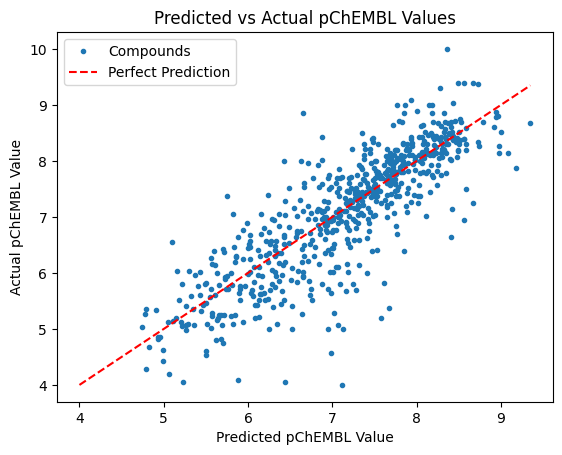

In [25]:
plt.plot(pred_y_test, y_test, '.', label="Compounds" )

min_val = min(min(y_test), min(pred_y_test))
max_val = max(min(y_test), max(pred_y_test))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction' )

plt.xlabel("Predicted pChEMBL Value")
plt.ylabel("Actual pChEMBL Value")
plt.title("Predicted vs Actual pChEMBL Values")
plt.legend()

plt.show()

## Part 8: SAVE MODEL

In [26]:
joblib.dump(best_model, "best_MODEL.PARP")
print("✅ Model saved as best_MODEL.PARP")

✅ Model saved as best_MODEL.PARP


## Part 9: Predicting Bioactivity and Virtual Screening


### 9.1 Preparing External Screening Libraries


* Data cleaning of test sets
* Descriptor alignment with training data

### 9.2 Batch Prediction Pipelines

* High‑throughput prediction
* Ranking compounds by predicted activity
* Activity cutoffs

In [27]:
# ===========================
# EXAMPLE 9A: LOAD & CLEAN TEST DATA
# ===========================

# Load test dataset
test_df = pd.read_csv("Test.csv")

# Defensive column selection
required_cols = ["Smiles"]
test_df = test_df[required_cols + [c for c in test_df.columns if c not in required_cols]]

# Track initial size
initial_test_rows = test_df.shape[0]

# Drop missing SMILES
test_df = test_df.dropna(subset=["Smiles"]).reset_index(drop=True)

# Ensure correct data type and normalize
test_df["Smiles"] = test_df["Smiles"].astype(str).str.strip()

# Remove duplicate SMILES
test_df = test_df.drop_duplicates(subset=["Smiles"]).reset_index(drop=True)

# Validate SMILES with RDKit
def is_valid_smiles(smi):
    return Chem.MolFromSmiles(smi) is not None

test_df["valid_smiles"] = test_df["Smiles"].apply(is_valid_smiles)
test_df = test_df[test_df["valid_smiles"]].drop(columns="valid_smiles").reset_index(drop=True)

# Report cleaning summary
print(
    f"Test dataset cleaned: "
    f"{initial_test_rows - test_df.shape[0]} rows removed, "
    f"{test_df.shape[0]} valid compounds remaining."
)


Test dataset cleaned: 4422 rows removed, 6199 valid compounds remaining.


In [28]:
# ===========================
# EXAMPLE 9B: PREDICTION & ACTIVITY SUMMARY
# ===========================

# Generate predictions
test_df_with_ecfp = calculate_fingerprints(test_df, smiles_col='Smiles', method='ecfp', radius=2, nBits=1024)
PARP_X = test_df_with_ecfp.drop(columns=['Smiles', 'Compound Name ID'])
PARP_X_aligned = PARP_X.reindex(columns=X_train.columns, fill_value=0)
test_df['Predictions'] = best_model.predict(PARP_X_aligned)


[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerator
[22:57:13] DEPRECATION WARNING: please use MorganGenerat

In [29]:
test_df

,Smiles,Compound Name ID,Predictions
0,[2H]N1C=NC2=CC=CC=C21,(1-~2~H)-1H-Benzimidazole,5.556158
1,[2H]C1=NC2=CC=CC=C2N1,"(2-(2)H)-1H-1,3-benzodiazole",6.282943
2,C1=CC=C2C(=C1)NC=N2,Benzimidazole,5.587283
3,C1=C2C(=CN=N1)N=CN2,"1H-Imidazo[4,5-d]pyridazine",5.873869
4,C1=CC2=C(N=C1)N=C[NH2+]2,"1H-imidazo[4,5-b]pyridin-1-ium",5.355801
...,...,...,...
6194,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CN,"8-(aminomethyl)-1,3-dimethyl-7H-purine-2,6-dione",6.080705
6195,CC1=CC=C(C=C1)NCCCl,"Benzenamine, N-(2-chloroethyl)-4-methyl-",5.597769
6196,CC1=C2C=CC(=O)C=CC2=C(N1C)C,"Cyclohepta(c)pyrrol-6(2H)-one, 1,2,3-trimethyl-",6.709030
6197,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CO,8-(Hydroxymethyl)theophylline,6.110734


In [32]:
# EXAMPLE 9C: Classify activity
threshold = 6.0
test_df["Activity"] = (test_df["Predictions"] >= threshold).astype(int)

# Summary report
num_active = test_df["Activity"].sum()
num_total = len(test_df)
print(f"✅ Activity Summary (Threshold = {threshold}):")
print(f"Total molecules evaluated: {num_total}")
print(f"Predicted active molecules: {num_active}")
print(f"Predicted inactive molecules: {num_total - num_active}")
print(f"Percentage active: {num_active / num_total * 100:.2f}%")


✅ Activity Summary (Threshold = 6.0):
Total molecules evaluated: 6199
Predicted active molecules: 3444
Predicted inactive molecules: 2755
Percentage active: 55.56%


In [33]:
test_df

,Smiles,Compound Name ID,Predictions,Activity
0,[2H]N1C=NC2=CC=CC=C21,(1-~2~H)-1H-Benzimidazole,5.556158,0
1,[2H]C1=NC2=CC=CC=C2N1,"(2-(2)H)-1H-1,3-benzodiazole",6.282943,1
2,C1=CC=C2C(=C1)NC=N2,Benzimidazole,5.587283,0
3,C1=C2C(=CN=N1)N=CN2,"1H-Imidazo[4,5-d]pyridazine",5.873869,0
4,C1=CC2=C(N=C1)N=C[NH2+]2,"1H-imidazo[4,5-b]pyridin-1-ium",5.355801,0
...,...,...,...,...
6194,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CN,"8-(aminomethyl)-1,3-dimethyl-7H-purine-2,6-dione",6.080705,1
6195,CC1=CC=C(C=C1)NCCCl,"Benzenamine, N-(2-chloroethyl)-4-methyl-",5.597769,0
6196,CC1=C2C=CC(=O)C=CC2=C(N1C)C,"Cyclohepta(c)pyrrol-6(2H)-one, 1,2,3-trimethyl-",6.709030,1
6197,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CO,8-(Hydroxymethyl)theophylline,6.110734,1


## Part 10: Further Applications: Lipinski Filter (Drug Likeness)

In [34]:
#EXAMPLE 10A: Lipinski Filtering

from rdkit.Chem import Descriptors

# Compute molecular descriptors

def safe_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol if mol else None

test_df["Mol"] = test_df["Smiles"].apply(safe_mol)
test_df = test_df[test_df["Mol"].notnull()]

test_df["Mol"] = test_df["Smiles"].apply(lambda x: Chem.MolFromSmiles(x))
test_df['MolWt'] = test_df['Mol'].apply(Descriptors.MolWt)
test_df['LogP'] = test_df['Mol'].apply(Descriptors.MolLogP)
test_df['nHA'] = test_df['Mol'].apply(Descriptors.NumHAcceptors)
test_df['nHD'] = test_df['Mol'].apply(Descriptors.NumHDonors)

# Apply Lipinski rule
def calculate_lipinski(row):
    if row['MolWt'] > 500 or row['LogP'] > 5 or row['nHA'] > 10 or row['nHD'] > 5:
        return 0
    else:
        return 1

Choice_Compounds = test_df[test_df["Activity"] == 1].copy()
Choice_Compounds["Lipinski"] = Choice_Compounds.apply(calculate_lipinski, axis=1)
lipinski_pass = Choice_Compounds[Choice_Compounds["Lipinski"] == 1]


In [37]:
lipinski_pass

,Smiles,Compound Name ID,Predictions,Activity,Mol,MolWt,LogP,nHA,nHD,Lipinski
1,[2H]C1=NC2=CC=CC=C2N1,"(2-(2)H)-1H-1,3-benzodiazole",6.282943,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,119.145102,1.56290,1,1,1
5,C1=CC=C2C(=C1)NC=[NH+]2,1H-benzimidazol-3-ium,6.025876,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,119.147000,0.98200,0,1,1
6,C1=CC2=C(N=C1)N=CN2,"Imidazo(4,5-b)pyridine",6.109238,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,119.127000,0.95790,2,1,1
7,[2H]N1C2=CC=CC=C2N=N1,(1-~2~H)-1H-Benzotriazole,6.515612,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,120.133102,0.95790,2,1,1
8,[2H]C1=C(C(=C2C(=C1[2H])NN=N2)[2H])[2H],Benzotriazole-d4,7.356536,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,123.151407,0.95790,2,1,1
...,...,...,...,...,...,...,...,...,...,...
6191,CC1=CC(=O)N(C2=NC(=NN12)SC)C,"4,7-dimethyl-2-(methylthio)[1,2,4]triazolo[1,5...",7.084429,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,210.262000,0.45832,6,0,1
6194,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CN,"8-(aminomethyl)-1,3-dimethyl-7H-purine-2,6-dione",6.080705,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,209.209000,-1.58100,6,2,1
6196,CC1=C2C=CC(=O)C=CC2=C(N1C)C,"Cyclohepta(c)pyrrol-6(2H)-one, 1,2,3-trimethyl-",6.709030,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,187.242000,2.15534,2,0,1
6197,CN1C2=C(C(=O)N(C1=O)C)NC(=N2)CO,8-(Hydroxymethyl)theophylline,6.110734,1,<rdkit.Chem.rdchem.Mol object at 0x000001B691E...,210.193000,-1.54740,6,2,1


In [38]:
#EXAMPLE 10B: Drop Unnessary Columns and save output

Lipinski_Pass_Compounds= lipinski_pass.drop(columns=['Mol','MolWt', 'LogP', 'nHA', 'nHD'])
Lipinski_Pass_Compounds.to_csv("PARP_lipinski_pass_6.5_CPDS.csv", index=False)
print("✅ Saved Lipinski-passing compounds")

✅ Saved Lipinski-passing compounds
